In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model, load_model
import cv2
import matplotlib.pyplot as plt
import contextlib
import os
import glob
import sys
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import shutil
import pandas as pd
import matplotlib.patches as patches
from PIL import Image

In [2]:
# Función Grad-CAM 
def grad_cam(model, img_array, layer_name, pred_index):
    # Obtener el submodelo que contiene las capas convolucionales
    base_model = model.get_layer('model')
    # Crear un modelo que tenga como entrada la entrada del submodelo base y salida de la capa interna
    grad_model = Model(inputs=base_model.input, # Entrada del submodelo base
                       outputs=[base_model.get_layer(layer_name).output, base_model.output]) # Acceso directo a la capa del modelo
    
    with tf.GradientTape() as tape:
        inputs = tf.cast(img_array, tf.float32)
        tape.watch(inputs)
        conv_outputs, predictions = grad_model(inputs)
        class_channel = predictions[:, pred_index]  # Seleccionar el canal de la clase correspondiente

    grads = tape.gradient(class_channel, conv_outputs) # Obtener los gradientes de la clase predicha con respecto a la salida de la capa de convolución
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2)) # Calcular el promedio de los gradientes en cada canal
    # Ponderar la salida de la convolución con los gradientes promedio
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) # Aplicar ReLU para eliminar valores negativos

    if tf.math.reduce_max(heatmap) > 0:
        heatmap /= tf.math.reduce_max(heatmap)

    return np.clip(heatmap, 0, 1) # Devolver las dimensiones de la capa

# Aplicar Grad-CAM en cada fragmento y generar un mapa de calor
def apply_heatmap_on_image(image, heatmap, alpha=0.4):
    heatmap = cv2.resize(heatmap, (image.shape[1], image.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    superimposed_img = cv2.addWeighted(image, 1-alpha, heatmap, alpha, 0)
    return superimposed_img

In [3]:
# Cargar el modelo guardado
model = load_model("modelo_entrenado_2.h5", compile=False)

# Mostrar la estructura del modelo para verificar la carga correcta
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 128, 128, 3)]     0         
                                                                 
 model (Functional)          (None, 4, 4, 1280)        4049571   
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout_1 (Dropout)         (None, 1280)              0         
                                                                 
 dense_1 (Dense)             (None, 512)               655872    
                                                                 
 dropout_2 (Dropout)         (None, 512)               0         
                                                           

In [4]:
# Obtener la capa 'model' del modelo principal
base_model = model.get_layer('model')

# Imprimir el resumen del submodelo
base_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 128, 128, 3)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 128, 128, 3)  7           ['rescaling[0][0]']              
                                                                                                  
 tf.math.truediv (TFOpLambda)   (None, 128, 128, 3)  0           ['normalization[0][0]']      

In [5]:
# Función para calcular la entropía de las predicciones
def calculate_entropy(probabilities):
    return -np.sum(probabilities * np.log(probabilities + 1e-10))

# Función de visualización 
def visualize_image_with_gradcam(model, image_path, layer_name="top_conv"):
    # Crear una carpeta temporal para contener la imagen
    temp_dir = './temp_dir'
    os.makedirs(temp_dir + '/temp', exist_ok=True)

    # Copiar la imagen a la carpeta temporal
    imagen_copiada = os.path.join(temp_dir + '/temp', os.path.basename(image_path))
    shutil.copy(image_path, imagen_copiada)

    # Crear el generador de datos
    datagen = ImageDataGenerator()

    # Configurar el generador de prueba
    prueba_generator = datagen.flow_from_directory(
        directory=temp_dir,
        target_size=(128, 128),
        batch_size=32,
        class_mode=None,
        color_mode='rgb',
        shuffle=False
    )

    for img_array in prueba_generator:
        # Nombres de las clases 
        class_names = ['Hallazgo', 'Sin Hallazgo']
        predictions = model.predict(img_array)
        predicted_class = np.argmax(predictions[0])
        confidence = predictions[0][predicted_class]

        # Calcular la entropía de la predicción
        entropy = calculate_entropy(predictions[0])
        
        # Visualizar Grad-CAM 
        heatmap = grad_cam(model, img_array, layer_name, predicted_class)
        img = (img_array[0] * 255).astype(np.uint8)  # Desescalar para mostrar correctamente
        superimposed_img = apply_heatmap_on_image(img, heatmap)
        
        plt.imshow(superimposed_img)
        plt.title(f"Grad Cam", fontsize=16, fontweight='bold')
        plt.axis('off')
        plt.colorbar(plt.cm.ScalarMappable(cmap='jet'), ax=plt.gca())

        # Añadir un texto con las métricas en la parte inferior de la imagen
        title_text = 'Resultados'
        metrics_text = (f'Clase predicha: {class_names[predicted_class]}\n'
                        f'Probabilidad: {confidence:.4f}\n'
                        f'Entropía: {entropy:.4f}\n')
        
        # Combinar el título y las métricas en un solo recuadro
        plt.figtext(0.5, 0.05, title_text, ha="center", va="top", fontsize=14, weight='bold', bbox={"facecolor": "lightgray", "alpha": 0})

        # Añadir las métricas, alineadas a la izquierda, justo debajo del título
        plt.figtext(0.35, 0.005, metrics_text, ha="left", va="top", fontsize=12, bbox={"facecolor": "lightgray", "alpha": 0})
        plt.axis("on") 
        plt.gca().invert_yaxis()
        plt.show()
        break  # Salir después de la primera imagen

    # Limpiar la carpeta temporal
    shutil.rmtree(temp_dir)

In [6]:
# Función para aplicar el texto con la clase en la imagen
def add_text_to_image(image, text, position=(10, 30), font_scale=0.6, color=(255, 255, 255), thickness=1):
    font = cv2.FONT_HERSHEY_SIMPLEX
    return cv2.putText(image, text, position, font, font_scale, color, thickness, cv2.LINE_AA)

# Función para suprimir la salida de la consola
@contextlib.contextmanager
def suppress_stdout():
    original_stdout = sys.stdout  # Guardar el valor de sys.stdout
    sys.stdout = open(os.devnull, 'w')  # Redirigir sys.stdout a null
    try:
        yield
    finally:
        sys.stdout.close()  # Cerrar el archivo temporal
        sys.stdout = original_stdout  # Restaurar sys.stdout

# Función para procesar y combinar los fragmentos en una imagen final
def process_and_visualize_fragments(model, fragment_dir, fragment_size, num_rows, num_cols, layer_name="top_conv"):
    final_image = np.zeros((fragment_size[0] * num_rows, fragment_size[1] * num_cols, 3), dtype=np.uint8)

    for i, num in enumerate(range(1, num_rows * num_cols + 1)):
        fragment_paths = glob.glob(os.path.join(fragment_dir, f'*_{num}.png'))
        if not fragment_paths:
            continue
        fragment_path = fragment_paths[0]

        # Crear una carpeta temporal para contener la imagen
        temp_dir = './temp_dir'
        os.makedirs(temp_dir + '/temp', exist_ok=True)

        # Copiar la imagen a la carpeta temporal
        imagen_copiada = os.path.join(temp_dir + '/temp', os.path.basename(fragment_path))
        shutil.copy(fragment_path, imagen_copiada)

        # Crear el generador de datos
        datagen = ImageDataGenerator()

        with suppress_stdout():
            prueba_generator = datagen.flow_from_directory(
                directory=temp_dir,
                target_size=fragment_size,
                batch_size=32,
                class_mode=None,
                color_mode='rgb',
                shuffle=False
            )

        for img_array in prueba_generator:
            predictions = model.predict(img_array, verbose=0)
            prediction_percentages = (predictions[0] * 100).round(0)  # Convertir a porcentaje y redondear

            # Formatear el texto de las dos clases y porcentajes 
            class_text = f'[{prediction_percentages[0]:.0f}%, {prediction_percentages[1]:.0f}%]'

            # Generar el mapa de calor con Grad-CAM e invertirlo
            predicted_class = np.argmax(predictions[0])
            heatmap = grad_cam(model, img_array, layer_name=layer_name, pred_index=predicted_class)
            heatmap = 1 - heatmap
            img = (img_array[0] * 255).astype(np.uint8)  # Desescalar para mostrar correctamente

            # Superponer el mapa de calor sobre la imagen original
            superimposed_img = apply_heatmap_on_image(img, heatmap)

            # Añadir el texto de todas las clases con sus porcentajes en el fragmento
            superimposed_img = add_text_to_image(superimposed_img, class_text)

            # Calcular la posición en la imagen final
            row = i // num_cols
            col = i % num_cols
            final_image[row * fragment_size[0]:(row + 1) * fragment_size[0],
                        col * fragment_size[1]:(col + 1) * fragment_size[1]] = superimposed_img
            break  # Procesar solo la primera imagen en el generador

        # Limpiar la carpeta temporal
        shutil.rmtree(temp_dir)

    return final_image

In [7]:
def mostrar_hallazgos_con_ajuste(image_path, registros, escala):
    # Cargar la imagen
    imagen = Image.open(image_path)
    img_width, img_height = imagen.size
    
    # Configurar el tamaño de la figura para reducir el tamaño de la imagen
    dpi = 100  # Densidad de píxeles por pulgada
    fig, ax = plt.subplots(1, figsize=(img_width / (dpi * escala), img_height / (dpi * escala)), dpi=dpi)
    ax.imshow(imagen, cmap="gray")

    # Lista para almacenar los detalles de cada hallazgo
    detalles_hallazgos = []

    for idx, (index, registro) in enumerate(registros.iterrows(), start=1):
        # Verificar si las coordenadas son válidas
        if pd.isna(registro['xmin']) or pd.isna(registro['ymin']) or pd.isna(registro['xmax']) or pd.isna(registro['ymax']):
            print(f"Las coordenadas de la anotación están incompletas para el hallazgo {idx} y serán omitidas.")
            continue

        # Obtener datos del registro y dimensiones originales
        breast_birads = registro['finding_birads']
        breast_density = registro.get('breast_density', 'N/A')
        finding_categories = registro.get('finding_categories', 'N/A')
        xmin = int(registro['xmin'])
        ymin = int(registro['ymin'])
        xmax = int(registro['xmax'])
        ymax = int(registro['ymax'])
        original_height = registro['height']
        original_width = registro['width']
        
        # Escalado de las coordenadas en base a las dimensiones de la imagen
        scale_x = img_width / original_width
        scale_y = img_height / original_height
        
        # Ajustar las coordenadas de acuerdo a la escala calculada
        xmin = int(xmin * scale_x)
        ymin = int(ymin * scale_y)
        xmax = int(xmax * scale_x)
        ymax = int(ymax * scale_y)

        # Crear el cuadro delimitador en color rojo con grosor
        ancho = xmax - xmin
        alto = ymax - ymin
        rect = patches.Rectangle((xmin, ymin), ancho, alto, linewidth=2, edgecolor='red', facecolor='none')
        ax.add_patch(rect)
        
        # Calcular la posición central superior para el número del hallazgo
        center_x = xmin + ancho / 2
        text_y = ymin - 10  # Ajustar el texto ligeramente arriba de ymin
        
        # Añadir el número de hallazgo en el cuadro, centrado en la parte superior
        ax.text(center_x, text_y, f"{idx}", color="white", fontsize=12, weight="bold", 
                ha="center", bbox=dict(facecolor='red', edgecolor='none', boxstyle="round,pad=0.3"))

        # Agregar detalles a la lista para la tabla
        detalles_hallazgos.append([idx, breast_density, finding_categories, breast_birads])

    # Mostrar la imagen con los cuadros y la numeración de los hallazgos
    plt.show()

    # Crear un DataFrame para mostrar los detalles de los hallazgos
    col_labels = ["# Hallazgo", "Densidad Mamaria", "Categorías de Hallazgo", "BI-RADS"]
    detalles_df = pd.DataFrame(detalles_hallazgos, columns=col_labels)

    # Mostrar el DataFrame como una tabla sin índice en el entorno Jupyter Notebook
    from IPython.display import HTML, display
    display(HTML(detalles_df.to_html(index=False)))

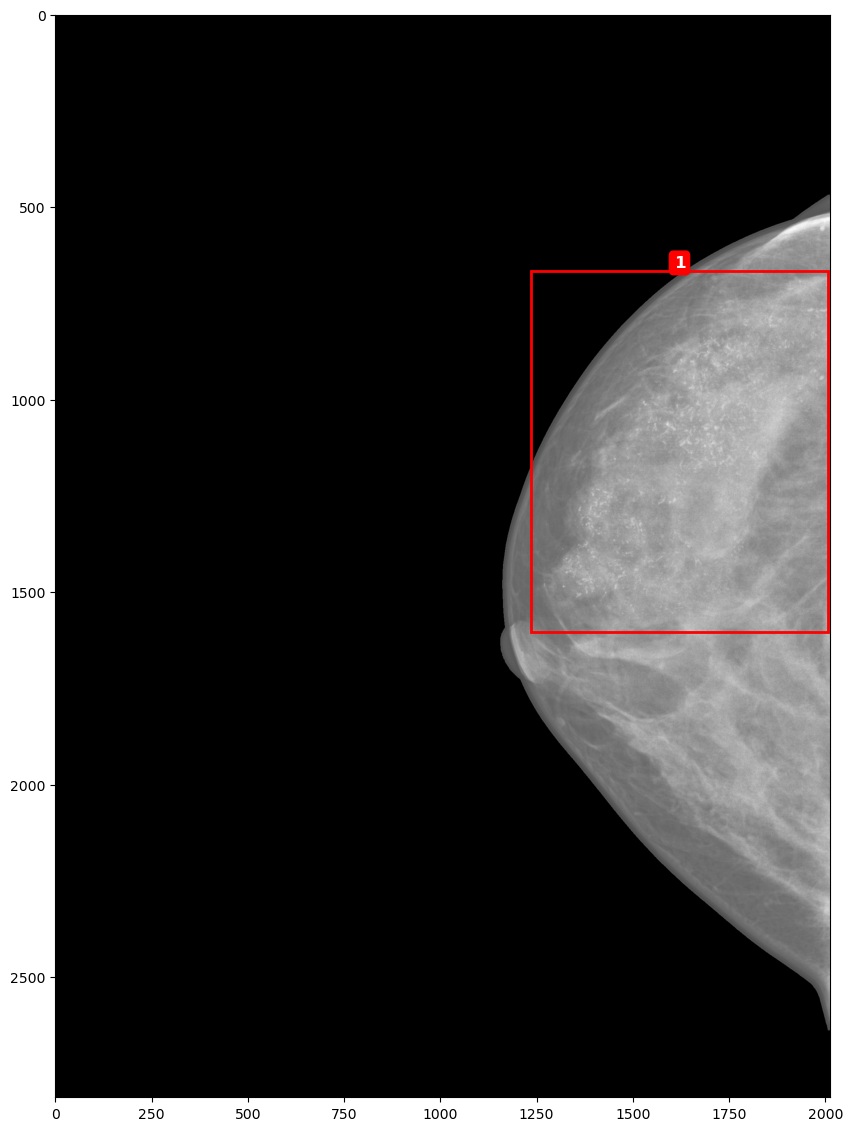

In [8]:
# Cargar el archivo de anotaciones
finding_annotations_path = "./finding_annotations.csv"
finding_annotations_df = pd.read_csv(finding_annotations_path)

# Definir el ID de la imagen a visualizar
image_id = "0f37159abdcef6a062e404df47e8f1ac"  # ID de la imagen
image_path = f"./4_dataset_negativo/{image_id}.png"  # Ruta de la imagen

# Filtrar todos los registros correspondientes al `image_id` especificado
registros = finding_annotations_df[finding_annotations_df['image_id'] == image_id]

# Llamar a la función para visualizar con ajuste de escala (por ejemplo, reducir tamaño a la mitad)
mostrar_hallazgos_con_ajuste(image_path, registros, escala=2)

**Fragmento región de hallazgo**

Found 1 images belonging to 1 classes.
1/1 [==============================] - 6s 6s/step


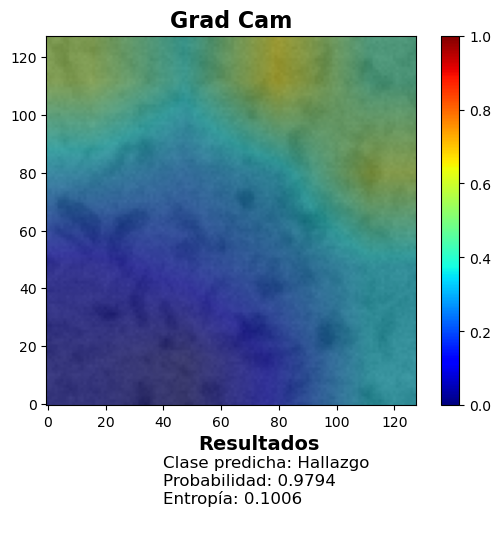

In [9]:
# Ejemplo de uso con la ruta de imagen proporcionada
image_path = r"fragmentos/0f37159abdcef6a062e404df47e8f1ac_1_BI-RADS_4_22.png"
visualize_image_with_gradcam(model, image_path)

**Fragmento negro**

Found 1 images belonging to 1 classes.
1/1 [==============================] - 0s 15ms/step


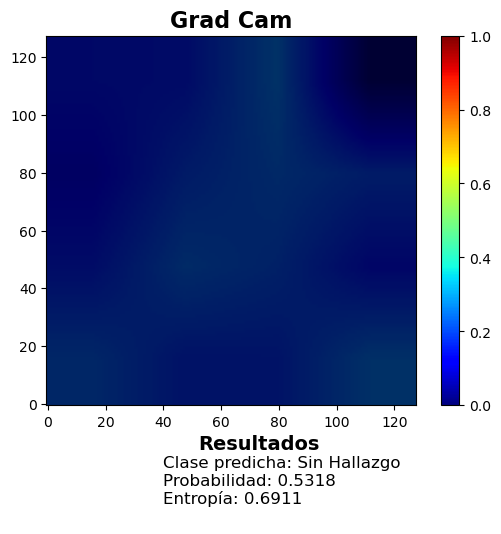

In [10]:
# Ejemplo de uso con la ruta de imagen proporcionada
image_path = r"fragmentos_1/0f37159abdcef6a062e404df47e8f1ac_1.png"
visualize_image_with_gradcam(model, image_path)

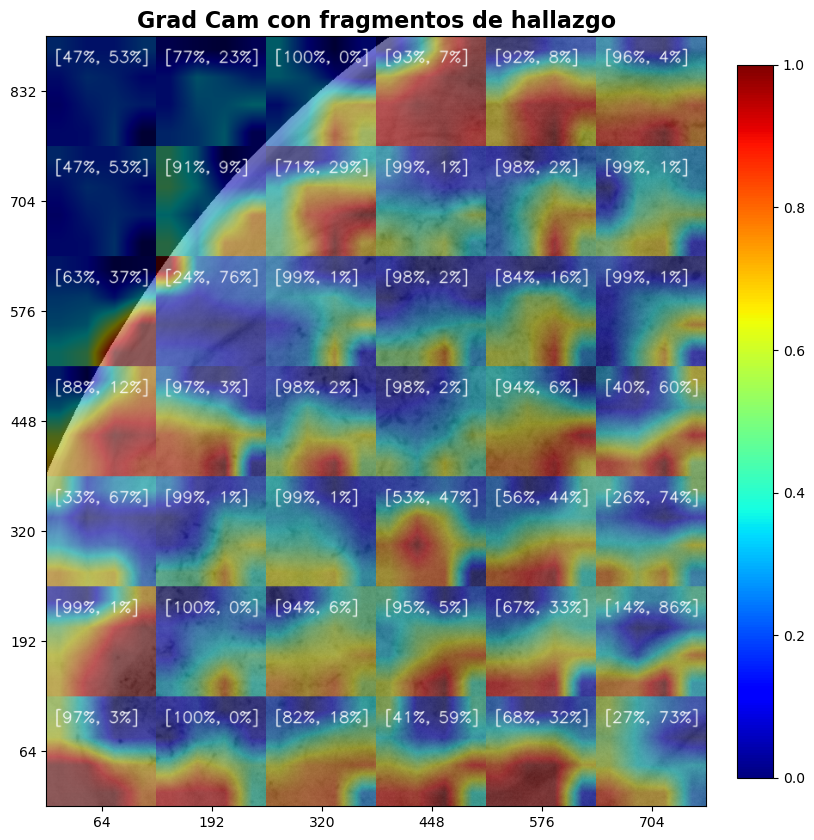

In [11]:
# Ejemplo de uso de la función
fragment_dir = 'fragmentos'  # Define tu directorio de fragmentos
fragment_size = (128, 128)  # Define el tamaño de cada fragmento
num_rows = 7  # Define el número de filas en la imagen final
num_cols = 6  # Define el número de columnas en la imagen final

# Procesar los fragmentos
final_image = process_and_visualize_fragments(model, fragment_dir, fragment_size, num_rows, num_cols)

# Invertir la imagen final verticalmente antes de mostrarla
final_image_inverted = cv2.flip(final_image, 0)

# Mostrar la imagen final con todos los fragmentos y sus mapas de calor
plt.figure(figsize=(10, 10))  # Ajusta el tamaño de la figura según lo que necesites
plt.imshow(cv2.cvtColor(final_image_inverted, cv2.COLOR_BGR2RGB), origin='lower')  # Usa la imagen original, sin inversión

# Modificar las unidades del eje x y y
x_ticks = np.arange(64, final_image.shape[1], 128)
y_ticks = np.arange(64, final_image.shape[0], 128)

# Asegurarse de que la última marca sea 64 si está en el rango
if final_image.shape[1] >= 64 and 64 not in x_ticks:
    x_ticks = np.append(64, x_ticks)
if final_image.shape[0] >= 64 and 64 not in y_ticks:
    y_ticks = np.append(64, y_ticks)
plt.xticks(x_ticks)
plt.yticks(y_ticks)
plt.title("Grad Cam con fragmentos de hallazgo", fontsize=16, fontweight='bold')
plt.axis('on')  # Mostrar los ejes con marcas
plt.gca().set_ylim([0, final_image.shape[0]])  # Configuración normal para que el origen esté en la esquina superior izquierda
plt.colorbar(plt.cm.ScalarMappable(cmap='jet'), ax=plt.gca(), fraction=0.046, pad=0.04)  # Añadir barra de colores
plt.show()

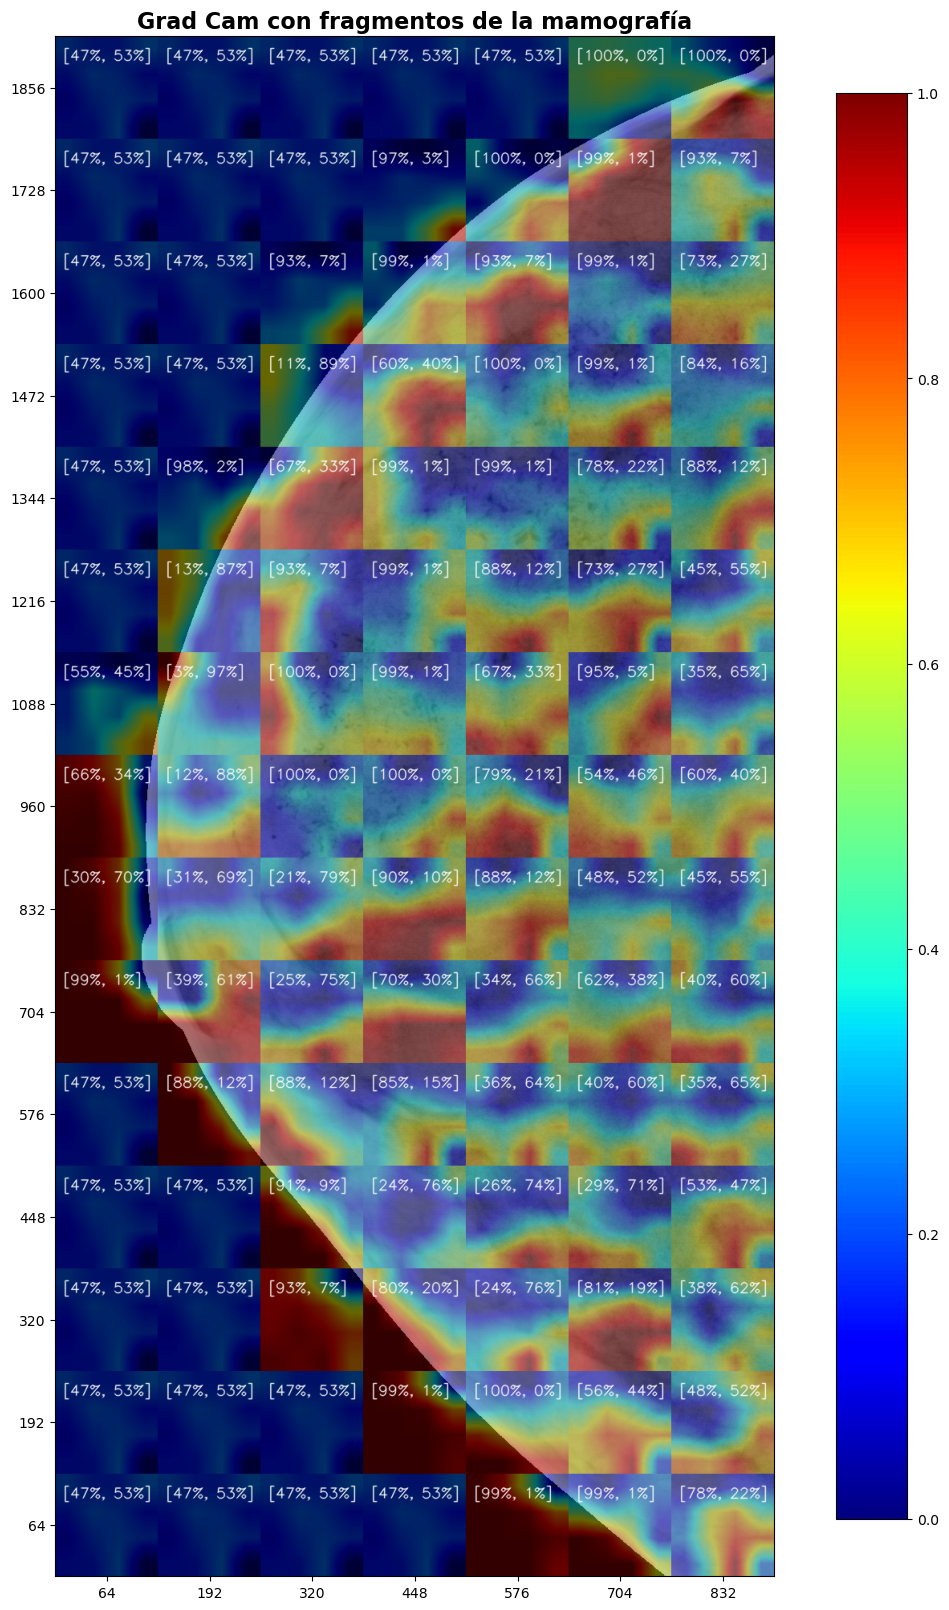

In [12]:
# Directorio donde se encuentran los fragmentos
fragment_dir = 'fragmentos_1'
fragment_size = (128, 128)  # Tamaño de los fragmentos
num_rows = 15  # Número de filas en la imagen final
num_cols = 7  # Número de columnas en la imagen final

# Procesar los fragmentos
final_image = process_and_visualize_fragments(model, fragment_dir, fragment_size, num_rows, num_cols)
# Invertir la imagen final verticalmente antes de mostrarla
final_image_inverted = cv2.flip(final_image, 0)

# Mostrar la imagen final con todos los fragmentos y sus mapas de calor
plt.figure(figsize=(20, 20))  # Ajusta el tamaño de la figura según lo que necesites
plt.imshow(cv2.cvtColor(final_image_inverted, cv2.COLOR_BGR2RGB), origin='lower')
x_ticks = np.arange(64, final_image.shape[1], 128)
y_ticks = np.arange(64, final_image.shape[0], 128)
if final_image.shape[1] >= 64 and 64 not in x_ticks:
    x_ticks = np.append(64, x_ticks)
if final_image.shape[0] >= 64 and 64 not in y_ticks:
    y_ticks = np.append(64, y_ticks)
plt.xticks(x_ticks)
plt.yticks(y_ticks)
plt.title(f"Grad Cam con fragmentos de la mamografía", fontsize=16, fontweight='bold')
plt.axis('on')  # Mostrar los ejes con marcas
plt.gca().set_ylim([0, final_image.shape[0]])  # Configuración normal para que el origen esté en la esquina superior izquierda
plt.colorbar(plt.cm.ScalarMappable(cmap='jet'), ax=plt.gca(), fraction=0.046, pad=0.04)  # Añadir barra de colores
plt.show()

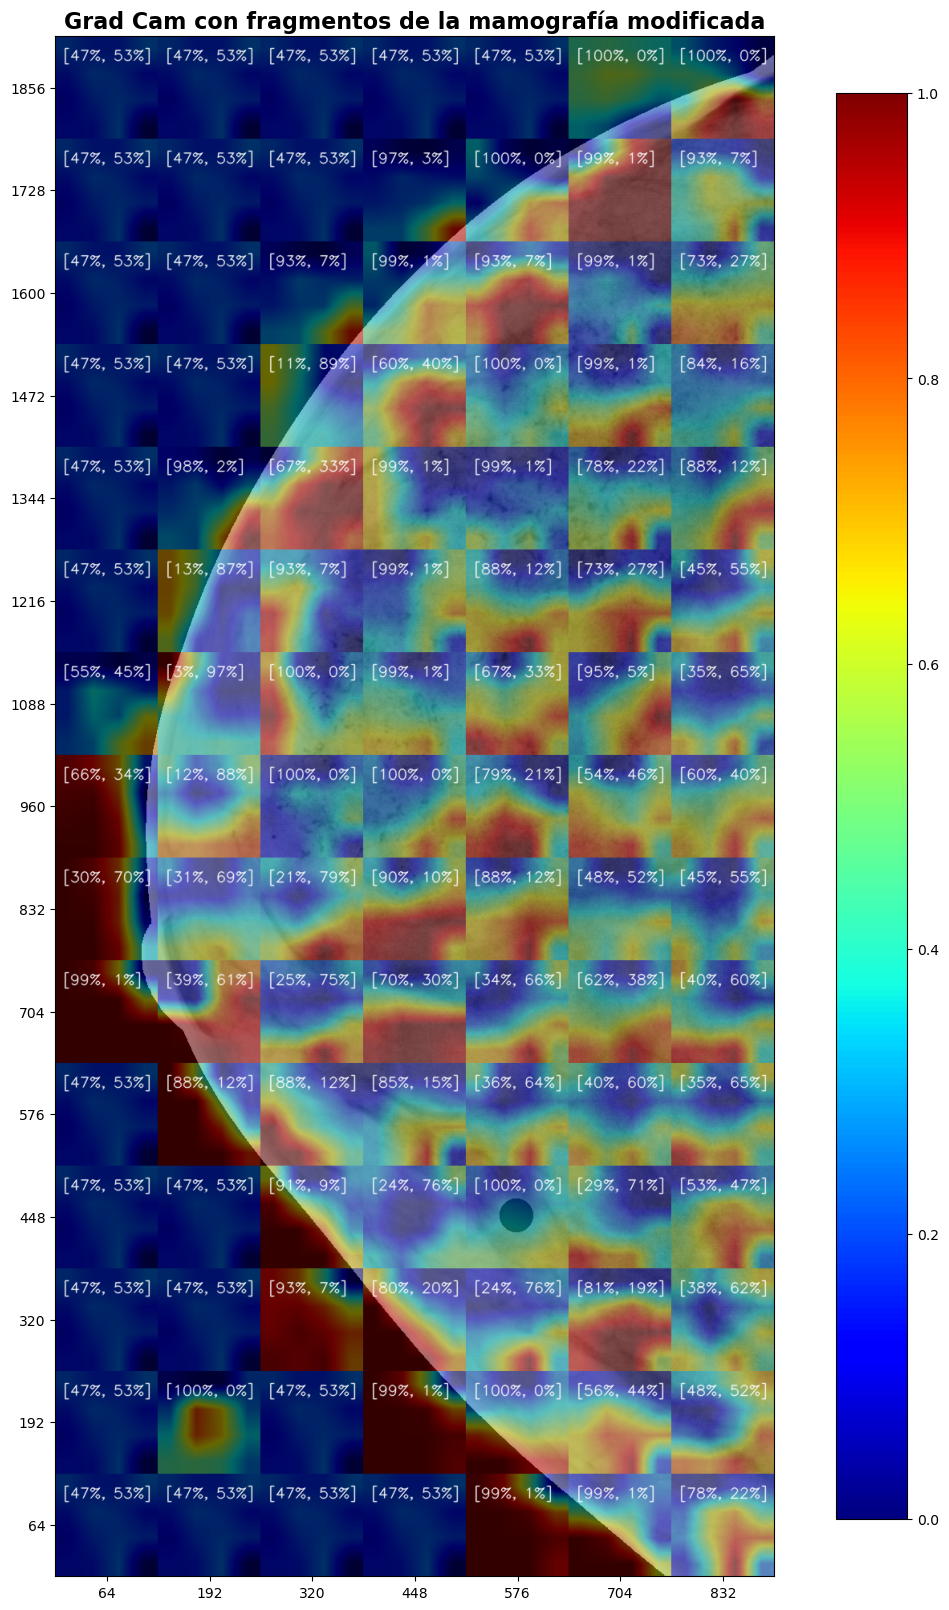

In [13]:
# Directorio donde se encuentran los fragmentos
fragment_dir = 'fragmentos_2'
fragment_size = (128, 128)  # Tamaño de los fragmentos
num_rows = 15  # Número de filas en la imagen final
num_cols = 7  # Número de columnas en la imagen final

# Procesar los fragmentos
final_image = process_and_visualize_fragments(model, fragment_dir, fragment_size, num_rows, num_cols)
# Invertir la imagen final verticalmente antes de mostrarla
final_image_inverted = cv2.flip(final_image, 0)

# Mostrar la imagen final con todos los fragmentos y sus mapas de calor
plt.figure(figsize=(20, 20))  # Ajusta el tamaño de la figura según lo que necesites
plt.imshow(cv2.cvtColor(final_image_inverted, cv2.COLOR_BGR2RGB), origin='lower')  # Usa la imagen original, sin inversión
x_ticks = np.arange(64, final_image.shape[1], 128)
y_ticks = np.arange(64, final_image.shape[0], 128)
if final_image.shape[1] >= 64 and 64 not in x_ticks:
    x_ticks = np.append(64, x_ticks)
if final_image.shape[0] >= 64 and 64 not in y_ticks:
    y_ticks = np.append(64, y_ticks)
plt.xticks(x_ticks)
plt.yticks(y_ticks)
plt.title(f"Grad Cam con fragmentos de la mamografía modificada", fontsize=16, fontweight='bold')
plt.axis('on')  # Mostrar los ejes con marcas
plt.gca().set_ylim([0, final_image.shape[0]])  # Configuración normal para que el origen esté en la esquina superior izquierda
plt.colorbar(plt.cm.ScalarMappable(cmap='jet'), ax=plt.gca(), fraction=0.046, pad=0.04)  # Añadir barra de colores
plt.show()

## Desfragmentar

In [14]:
'''import os
from PIL import Image

# Definir la imagen de origen y la carpeta de destino
input_image_path = "./dbfffde4219dfb6aab1a5fe2d21a99d0.png"
output_folder = "./fragmentos_4"
os.makedirs(output_folder, exist_ok=True)

# Tamaño de cada fragmento
tile_size = 128

try:
    # Abrir la imagen
    with Image.open(input_image_path) as img:
        img_width, img_height = img.size

        # Verificar si la imagen es suficientemente grande para dividirla en cuadros de 128x128
        if img_width < tile_size or img_height < tile_size:
            print(f"Imagen ignorada: dimensiones menores a {tile_size}x{tile_size}.")
        else:
            # Calcular el número de cuadros en ancho y alto
            tiles_x = img_width // tile_size
            tiles_y = img_height // tile_size

            # Generar fragmentos cuadrados
            tile_id = 1
            for y in range(tiles_y):
                for x in range(tiles_x):
                    # Definir las coordenadas del cuadro
                    left = x * tile_size
                    upper = y * tile_size
                    right = left + tile_size
                    lower = upper + tile_size

                    # Recortar el cuadro
                    tile = img.crop((left, upper, right, lower))

                    # Crear el nombre de archivo para el cuadro recortado
                    output_filename = f"{os.path.splitext(os.path.basename(input_image_path))[0]}_{tile_id}.png"
                    output_path = os.path.join(output_folder, output_filename)

                    # Guardar el cuadro recortado
                    tile.save(output_path)
                    print(f"Cuadro guardado: {output_filename}")
                    tile_id += 1

except Exception as e:
    print(f"Error al procesar la imagen: {e}")

print("Proceso completado.")'''

'import os\nfrom PIL import Image\n\n# Definir la imagen de origen y la carpeta de destino\ninput_image_path = "./dbfffde4219dfb6aab1a5fe2d21a99d0.png"\noutput_folder = "./fragmentos_4"\nos.makedirs(output_folder, exist_ok=True)\n\n# Tamaño de cada fragmento\ntile_size = 128\n\ntry:\n    # Abrir la imagen\n    with Image.open(input_image_path) as img:\n        img_width, img_height = img.size\n\n        # Verificar si la imagen es suficientemente grande para dividirla en cuadros de 128x128\n        if img_width < tile_size or img_height < tile_size:\n            print(f"Imagen ignorada: dimensiones menores a {tile_size}x{tile_size}.")\n        else:\n            # Calcular el número de cuadros en ancho y alto\n            tiles_x = img_width // tile_size\n            tiles_y = img_height // tile_size\n\n            # Generar fragmentos cuadrados\n            tile_id = 1\n            for y in range(tiles_y):\n                for x in range(tiles_x):\n                    # Definir las co

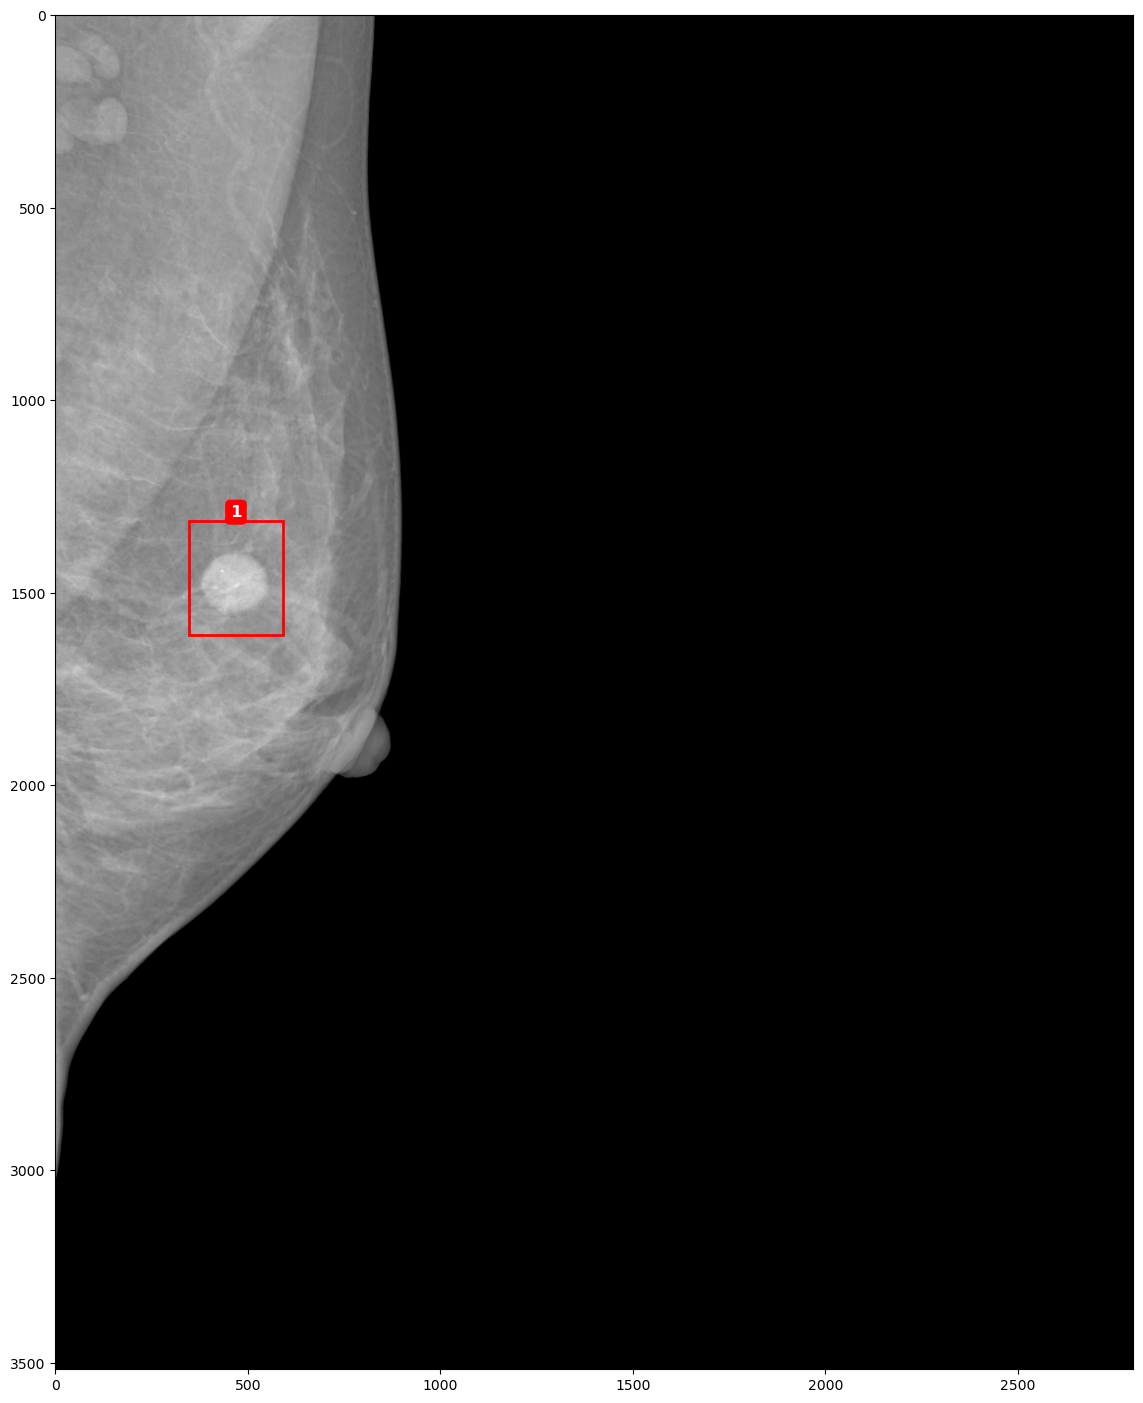

In [15]:
# Cargar el archivo de anotaciones
finding_annotations_path = "./finding_annotations.csv"
finding_annotations_df = pd.read_csv(finding_annotations_path)

# Definir el ID de la imagen a visualizar
image_id = "dbfffde4219dfb6aab1a5fe2d21a99d0"  # ID de la imagen
image_path = f"./4_dataset_negativo/{image_id}.png"  # Ruta de la imagen

# Filtrar todos los registros correspondientes al `image_id` especificado
registros = finding_annotations_df[finding_annotations_df['image_id'] == image_id]

# Llamar a la función para visualizar con ajuste de escala (por ejemplo, reducir tamaño a la mitad)
mostrar_hallazgos_con_ajuste(image_path, registros, escala=2)

Found 1 images belonging to 1 classes.
1/1 [==============================] - 0s 19ms/step


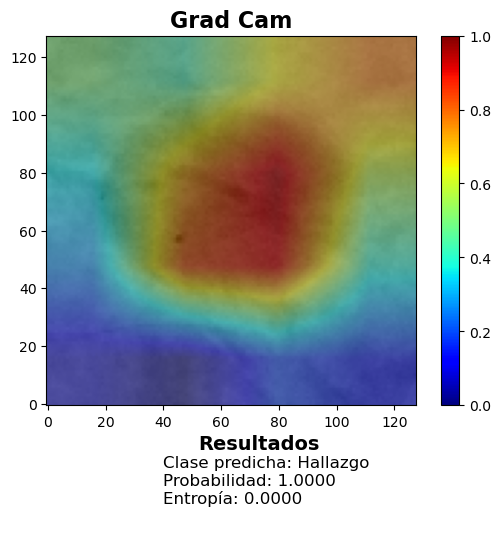

In [16]:
# Ejemplo de uso con la ruta de imagen proporcionada
image_path = r"dbfffde4219dfb6aab1a5fe2d21a99d0_1_BI-RADS_4.png"
visualize_image_with_gradcam(model, image_path)

Found 1 images belonging to 1 classes.
1/1 [==============================] - 0s 21ms/step


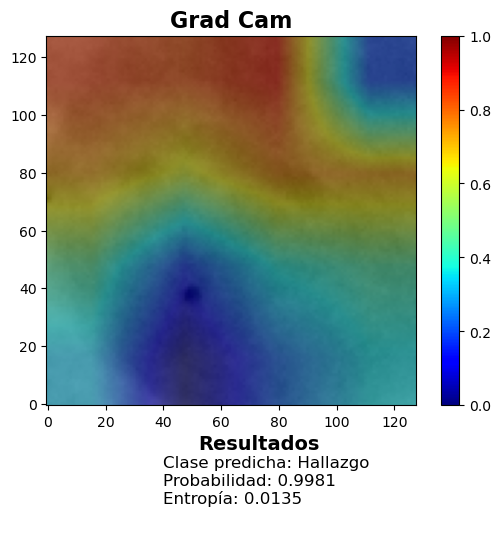

In [17]:
# Ejemplo de uso con la ruta de imagen proporcionada
image_path = r"fragmentos_4/dbfffde4219dfb6aab1a5fe2d21a99d0_92.png"
visualize_image_with_gradcam(model, image_path)

Found 1 images belonging to 1 classes.
1/1 [==============================] - 0s 24ms/step


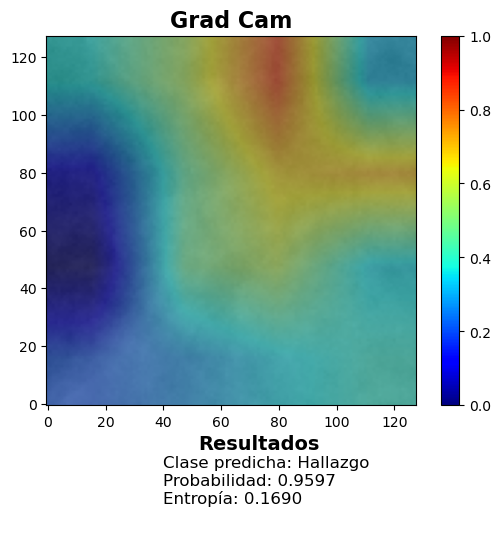

In [18]:
# Ejemplo de uso con la ruta de imagen proporcionada
image_path = r"fragmentos_4/dbfffde4219dfb6aab1a5fe2d21a99d0_93.png"
visualize_image_with_gradcam(model, image_path)

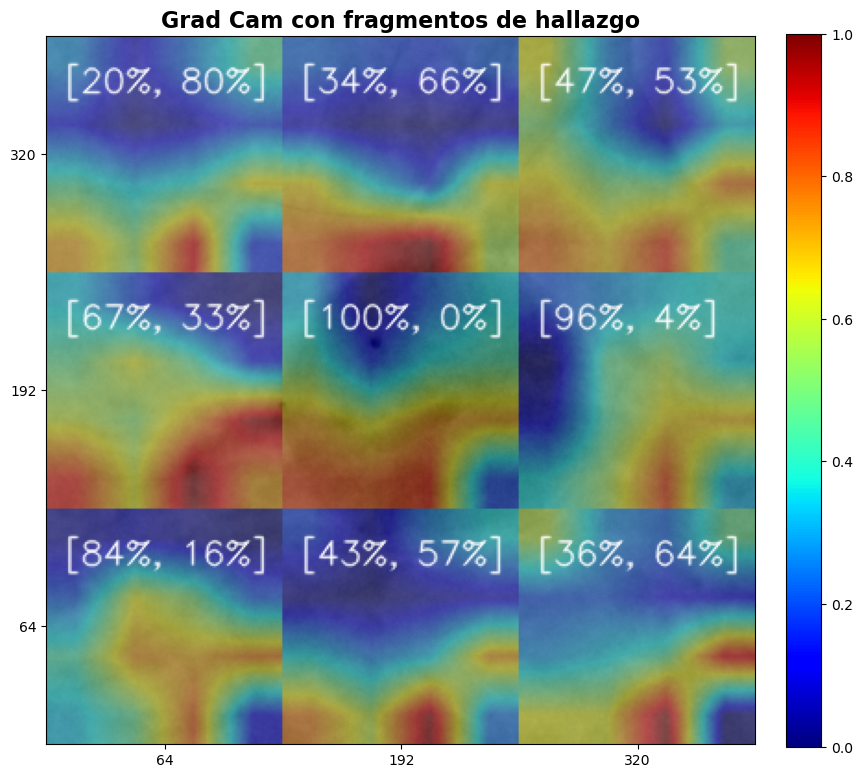

In [19]:
# Ejemplo de uso de la función
fragment_dir = 'fragmentos_3'  # Define tu directorio de fragmentos
fragment_size = (128, 128)  # Define el tamaño de cada fragmento
num_rows = 3  # Define el número de filas en la imagen final
num_cols = 3  # Define el número de columnas en la imagen final

# Procesar los fragmentos
final_image = process_and_visualize_fragments(model, fragment_dir, fragment_size, num_rows, num_cols)
# Invertir la imagen final verticalmente antes de mostrarla
final_image_inverted = cv2.flip(final_image, 0)

# Mostrar la imagen final con todos los fragmentos y sus mapas de calor
plt.figure(figsize=(10, 10))  # Ajusta el tamaño de la figura según lo que necesites
plt.imshow(cv2.cvtColor(final_image_inverted, cv2.COLOR_BGR2RGB), origin='lower')  # Usa la imagen original, sin inversión
# Modificar las unidades del eje x y y
x_ticks = np.arange(64, final_image.shape[1], 128)
y_ticks = np.arange(64, final_image.shape[0], 128)
if final_image.shape[1] >= 64 and 64 not in x_ticks:
    x_ticks = np.append(64, x_ticks)
if final_image.shape[0] >= 64 and 64 not in y_ticks:
    y_ticks = np.append(64, y_ticks)
plt.xticks(x_ticks)
plt.yticks(y_ticks)
plt.title(f"Grad Cam con fragmentos de hallazgo", fontsize=16, fontweight='bold')
plt.axis('on')  # Mostrar los ejes con marcas
plt.gca().set_ylim([0, final_image.shape[0]])  # Configuración normal para que el origen esté en la esquina superior izquierda
plt.colorbar(plt.cm.ScalarMappable(cmap='jet'), ax=plt.gca(), fraction=0.046, pad=0.04)  # Añadir barra de colores
plt.show()

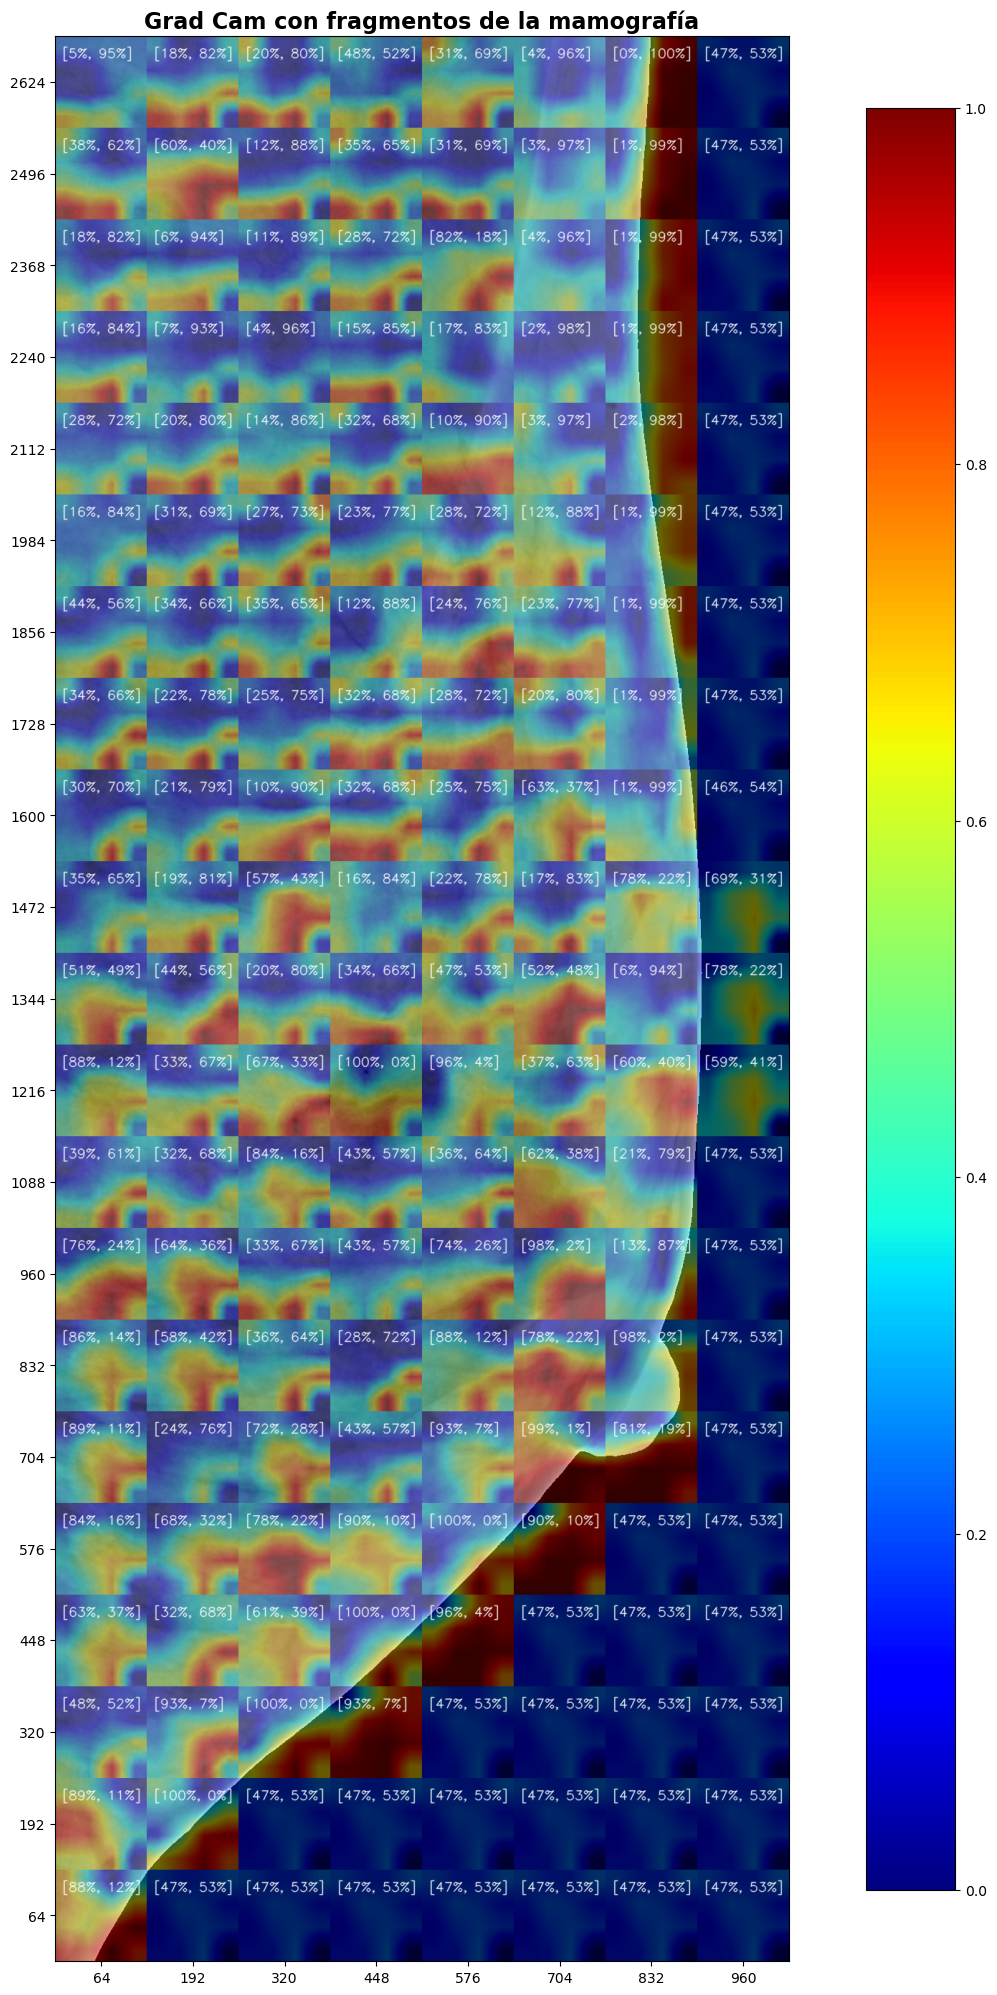

In [20]:
# Directorio donde se encuentran los fragmentos
fragment_dir = 'fragmentos_4'
fragment_size = (128, 128)  # Tamaño de los fragmentos
num_rows = 21  # Número de filas en la imagen final
num_cols = 8  # Número de columnas en la imagen final

# Procesar los fragmentos
final_image = process_and_visualize_fragments(model, fragment_dir, fragment_size, num_rows, num_cols)
# Invertir la imagen final verticalmente antes de mostrarla
final_image_inverted = cv2.flip(final_image, 0)

# Mostrar la imagen final con todos los fragmentos y sus mapas de calor
plt.figure(figsize=(25, 25))  # Ajusta el tamaño de la figura según lo que necesites
plt.imshow(cv2.cvtColor(final_image_inverted, cv2.COLOR_BGR2RGB), origin='lower')  # Usa la imagen original, sin inversión
x_ticks = np.arange(64, final_image.shape[1], 128)
y_ticks = np.arange(64, final_image.shape[0], 128)
if final_image.shape[1] >= 64 and 64 not in x_ticks:
    x_ticks = np.append(64, x_ticks)
if final_image.shape[0] >= 64 and 64 not in y_ticks:
    y_ticks = np.append(64, y_ticks)
plt.xticks(x_ticks)
plt.yticks(y_ticks)
plt.title(f"Grad Cam con fragmentos de la mamografía", fontsize=16, fontweight='bold')
plt.axis('on')  # Mostrar los ejes con marcas
plt.gca().set_ylim([0, final_image.shape[0]])  # Configuración normal para que el origen esté en la esquina superior izquierda
plt.colorbar(plt.cm.ScalarMappable(cmap='jet'), ax=plt.gca(), fraction=0.046, pad=0.04)  # Añadir barra de colores
plt.show()